In [1]:
pip install pyvista

Note: you may need to restart the kernel to use updated packages.


In [2]:
from netgen.occ import *
from ngsolve import *
from ngsolve.webgui import Draw
import os
import pyvista as pv
import numpy as np
import torch

directory = './images/'

In [3]:
def BaseShape(l, w):
    wp1 = WorkPlane().RectangleC(l,w).Face()
    wp2 = WorkPlane().RectangleC(w,l).Face()
    cross = wp1 + wp2
    return cross


l = 0.5
w = 1.5
base = BaseShape(l, w)

In [4]:
offset = 3
figure = base
for i in range(3):
    for j in range(3):
        if (i+j) % 2 == 0:
            figure += BaseShape(i,j).Move((i*offset, j*offset, 0))
        else:
            if i+j == 1:
                figure += WorkPlane().Circle(1).Face().Move((i*offset, j*offset, 0))
            else:
                figure += base.Mirror(Axis((0, 0, 0), (0, 1, 0))
                      ).Move((i*offset, j*offset, 0))


geo = WorkPlane().Rectangle(5,5).Face() -  figure.Move((-2,-2,0))
#square = WorkPlane().Rectangle(5,5).Face()
#Draw(geo)
#Draw(square)

geo.edges.Min(Y).name ='bottom'
geo.edges.Max(Y).name ='top'
geo.edges.Min(X).name ='left'
geo.edges.Max(X).name ='right'

#square.edges.Min(Y).name ='bottom'
#square.edges.Max(Y).name ='top'
#square.edges.Min(X).name ='left'
#square.edges.Max(X).name ='right'

In [5]:
plate = OCCGeometry(geo, dim=2)
#plate = OCCGeometry(square, dim=2)
mesh = Mesh(plate.GenerateMesh(maxh=0.5)).Curve(3)

mesh_point_count_0 = len(mesh.vertices)
vertex_coordinate_0 = []
    
for v in mesh.vertices:
    vertex_coordinate_0.append(v.point)
    
    mesh_x, mesh_y = zip(*vertex_coordinate_0)
    mesh_x = np.array(mesh_x)
    mesh_y = np.array(mesh_y)

    vertex_coordinates_0 = [mesh_x, mesh_y]

#print(mesh_y)
#print(vertex_coordinates_0)
#Draw (mesh);

In [6]:
def solve_FEM():
    # H1-conforming finite element space
    fes = H1(mesh, order=1, dirichlet="bottom", autoupdate=True)
    # define trial- and test-functions
    u = fes.TrialFunction()
    v = fes.TestFunction()
    
    # the bilinear-form 
    a = BilinearForm(grad(u)*grad(v)*dx)
    
    funcf = 1*x*y
    # funcf = 50*sin(y)
    f = LinearForm(funcf*v*dx)
    
    a.Assemble()
    f.Assemble()
    # Draw(funcf,mesh)
    gfu = GridFunction(fes)
    gfu.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs()) * f.vec
    return gfu, fes

In [7]:
def export_vertex_coordinates(mesh):
    vertex_coordinates = []
    
    for v in mesh.vertices:
        vertex_coordinates.append(v.point)
    
    vertex_array = torch.tensor(np.array(vertex_coordinates))
    
    return vertex_array

In [8]:
def export_fem_solution(mesh, gfu):
    vertex_array = export_vertex_coordinates(mesh).to(torch.float32)
    mesh_x , mesh_y = vertex_array.T   
    solution_array =  torch.tensor([x for x in gfu.vec])
    return solution_array

In [9]:
gfu, fes = solve_FEM()

In [10]:
vertex_array  = export_vertex_coordinates(mesh)
solution_array = export_fem_solution(mesh,gfu)
mesh_x , mesh_y = vertex_array.T
print(type(mesh_x), mesh_x[:5], len(mesh_x))

<class 'torch.Tensor'> tensor([0., 0., 3., 3., 5.], dtype=torch.float64) 112


In [11]:
import torch
import numpy as np
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure
from matplotlib.markers import MarkerStyle
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [12]:
batch_size = 4
# Step 2: Create a TensorDataset
dataset = TensorDataset(vertex_array, solution_array.reshape(-1,1))

# Step 3: Create a DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [13]:
class FeedForward(nn.Module):

    def __init__(self, mesh_x, mesh_y):
        super(FeedForward, self).__init__()

        self.total_error_history = []
        self.boundary_error_history = []
        self.train_loss_history = []
        self.total_residual_history = []
        self.boundary_residual_history = []
        
        self.mesh_point_history = [vertex_coordinates_0]
        self.mesh_point_count_history = [mesh_point_count_0]

        self.optimizer = None
        
        # weights for the total loss function
        self.w_data     = 0.01   #loss_data
        self.w_interior = 1      #loss_interior
        self.w_bc       = 10      #loss_bc

        self.hidden_size = 50
        self.num_data = 10
        self.num_bd = 5000

        # 2 input features
        self.b1 = nn.Linear(2, self.hidden_size)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.b3 = nn.Linear(self.hidden_size, 1)

        # initialize weights
        nn.init.xavier_uniform_(self.b1.weight)
        nn.init.xavier_uniform_(self.b2.weight)
        nn.init.xavier_uniform_(self.b3.weight)

        self.mesh_x  = mesh_x
        self.mesh_y  = mesh_y
 
    def forward(self, x, y):  

        xy = torch.stack((x, y), dim=1)

        h1 = torch.tanh(self.b1(xy))
        h2 = torch.tanh(self.b2(h1))
        u = self.b3(h2)

        return u

    
    def compute_derivative(self, u, x, n):
        # General formula to compute the n-th order derivative of u = f(x) with respect to x
        if n == 0:
            return u
        else:
            du_dx = torch.autograd.grad(u, x, torch.ones_like(u).to(device),
                                        create_graph=True, retain_graph=True,
                                        allow_unused=True)[0]

        return self.compute_derivative(du_dx, x, n - 1)

    
    def PDE_residual(self, x, y, use_meshgrid = False):
        if use_meshgrid:

            X,Y = torch.meshgrid(x,y)
            xy = torch.stack((X.flatten(), Y.flatten()), dim=1)

        x = torch.tensor(x, dtype=torch.float32).to(device)
        y = torch.tensor(y, dtype=torch.float32).to(device)
        x.requires_grad=True
        y.requires_grad=True

        u = self.forward(x, y)

        d2u_dx2 = self.compute_derivative(u, x, 2)
        d2u_dy2 = self.compute_derivative(u, y, 2)

        residual = d2u_dx2 + d2u_dy2 + x*y  
        return residual

    
    def loss_data(self):
        # xy, u = next(iter(dataloader))
        torch.manual_seed(42)
        idx = torch.randint(len(dataset), (self.num_data,))
        xy, u = dataset[idx]
        
        x, y  = xy.unbind(axis=1)

        x = torch.tensor(x, dtype=torch.float32).to(device)
        y = torch.tensor(y, dtype=torch.float32).to(device)
        u = torch.tensor(u, dtype=torch.float32).to(device)

        u_pred = self.forward(x, y)
        loss_data = torch.mean(torch.square(u - u_pred))
        return loss_data

    
    def loss_interior(self): 
        res = self.PDE_residual(self.mesh_x, self.mesh_y)
        loss_residual = torch.mean(torch.square(res)) 
        return loss_residual

    
    def loss_boundary_condition(self):

        self.x_bottom = torch.linspace(0, 5, self.num_bd).reshape(-1)
        self.y_bottom = torch.zeros(1, self.num_bd).reshape(-1)

        bc_pred_bottom = self.forward(self.x_bottom.to(device), self.y_bottom.to(device))
        loss_bc_bottom = torch.mean(torch.square(bc_pred_bottom))

        loss_bc = loss_bc_bottom 
        return loss_bc

    
    def compute_losses(self):  
        loss_interior = self.loss_interior()
        loss_data = self.loss_data()
        loss_bc = self.loss_boundary_condition()
        return loss_interior, loss_data, loss_bc


    def closure(self):
        self.optimizer.zero_grad()
        loss_interior, loss_data, loss_bc = self.compute_losses() 
        total_loss = self.w_data * loss_data + self.w_interior * loss_interior + self.w_bc * loss_bc   
        total_loss.backward(retain_graph=True)
        return total_loss

    
    def get_training_history(self):
        loss_hist = np.array(self.train_loss_history)
        total_loss, loss_bc, loss_interior, loss_data = np.split(loss_hist, 4, axis=1)
        return total_loss, loss_bc, loss_interior, loss_data

    
    def plot_pinn_losses(self):
            total_loss, loss_interior, loss_data, loss_bc = self.get_training_history()

            plt.figure(figsize=(8, 6))

            plt.subplot(2, 2, 1)
            plt.plot(total_loss, marker=MarkerStyle('o', fillstyle='none'), color='black', label='Total Loss')
            plt.yscale('log')
            plt.legend()

            plt.subplot(2, 2, 2)
            plt.plot(loss_bc, marker=MarkerStyle('o', fillstyle='none'), color='red', label='Boundary Condition Loss')
            plt.yscale('log')
            plt.legend()

            plt.subplot(2, 2, 3)
            plt.plot(loss_interior, marker=MarkerStyle('o', fillstyle='none'), color='blue', label='Interior Loss')
            plt.yscale('log')
            plt.legend()

            plt.subplot(2, 2, 4)
            plt.plot(loss_data, marker=MarkerStyle('o', fillstyle='none'), color='green', label='Data Loss')
            plt.yscale('log')
            plt.legend()

            plt.tight_layout()
            plt.show()

    def plot_pde_residuals(self):
            plt.figure(figsize=(15, 4))
        
            plt.subplot(1, 3, 1)
            plt.plot(self.mesh_point_count_history, marker=MarkerStyle('o', fillstyle='none'), color='black', label='mesh point count')
            plt.legend()
        
            plt.subplot(1, 3, 2)
            plt.plot(self.total_residual_history, marker=MarkerStyle('o', fillstyle='none'), color='red', label='total residual')
            plt.yscale('log')
            plt.legend()
        
            plt.subplot(1, 3, 3)
            plt.plot(self.boundary_residual_history, marker=MarkerStyle('o', fillstyle='none'), color='red', label='boundary residual')
            plt.yscale('log')
            plt.legend()
        
            plt.tight_layout()
            plt.show()
    
    def plot_model_error(self): 
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.total_error_history, marker=MarkerStyle('o', fillstyle='none'), color='black', label='total error')
        plt.yscale('log')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(self.boundary_error_history, marker=MarkerStyle('o', fillstyle='none'), color='red', label='boundary error')
        plt.yscale('log')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = FeedForward(mesh_x=mesh_x, mesh_y = mesh_y).to(device)
print(model)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

cpu
FeedForward(
  (b1): Linear(in_features=2, out_features=50, bias=True)
  (b2): Linear(in_features=50, out_features=50, bias=True)
  (b3): Linear(in_features=50, out_features=1, bias=True)
)
Params: 2751


In [15]:
def train(self, epochs, optimizer='Adam', w_interior=1, w_bc=10, w_data=0.01, **kwargs):
        if optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), **kwargs)

        elif optimizer == 'L-BFGS':
            self.optimizer = torch.optim.LBFGS(self.parameters(), **kwargs)

        # Training loop
        for epoch in range(epochs+1):
            self.optimizer.step(self.closure)
            
            # track progress and accumulate loss data for plotting
            if epoch % 1000 == 0:
                loss_interior, loss_data, loss_bc = self.compute_losses()
                total_loss = loss_interior + loss_bc 

                self.train_loss_history.append([total_loss.cpu().detach().numpy(),
                                                loss_interior.cpu().detach().numpy(),
                                                loss_data.cpu().detach().numpy(),
                                                loss_bc.cpu().detach().numpy(),
                                                
                                                ])

                print(f'Epoch ({optimizer}): {epoch}, Total PINN Loss: {total_loss.detach().cpu().numpy()}')

In [16]:
def export_to_png(mesh, gfu, fieldname, filename, size=600):
    vtk = VTKOutput(mesh,coefs=[gfu],names=[fieldname],filename="./vtk_export",subdivision=0)
    vtk.Do()
        
    # Read the VTU file
    meshpv = pv.read("./vtk_export.vtu")
    
    
    # Step 2: Check if the "sol" field exists
    if fieldname in meshpv.point_data:
    
        plotter = pv.Plotter(window_size=[size, size])
        plotter.add_mesh(meshpv, scalars=fieldname, show_scalar_bar=True, cmap='bwr')  
        plotter.add_mesh(meshpv, color="white", style="wireframe", show_scalar_bar=False)
        plotter.view_xy()
        plotter.scalar_bar.SetPosition(0.85, 0.15)  # Position (x, y) between 0 and 1
        plotter.scalar_bar.SetOrientationToVertical()
        plotter.scalar_bar.SetWidth(0.05)
        plotter.scalar_bar.SetHeight(0.7)
        # plotter.scalar_bar.SetLabelFormat("%-#6.0f") 
        plotter.scalar_bar.SetLabelFormat("%2.2e") 
        
        plotter.show(screenshot=directory+filename)

In [17]:
export = False

def get_model_error(model, mesh, gfu):
    u_pred = model.forward(model.mesh_x.to(device).float(), model.mesh_y.to(device).float())
    u_pred = u_pred.detach().cpu().numpy()
    u_plot = GridFunction(fes)
    u_plot.vec[:] = BaseVector(u_pred.flatten())
    
    if not os.path.exists(directory): # Create the directory if it does not exist 
        os.makedirs(directory)
        
    error = (u_plot - gfu)*(u_plot - gfu)
    model_error = Integrate(error, mesh, VOL, element_wise=True)

    total_error = Integrate(error, mesh, VOL)
    boundary_error = Integrate(error, mesh, BND)
    
    
    model.total_error_history.append(total_error)
    model.boundary_error_history.append(boundary_error)
    
    if export:
        export_to_png(mesh,(u_plot - gfu)*(u_plot - gfu),
                      fieldname = 'errors',
                      filename =  'errors_'+str(iteration))


In [18]:
def refine_mesh(model, fe_space, mesh):
    res = model.PDE_residual(model.mesh_x, model.mesh_y).detach().numpy()
    residuals = GridFunction(fe_space)
    residuals.vec[:] = BaseVector(res.flatten())
    residuals = (residuals)*(residuals) #integrate not element-wise but over entire domain to get one number
    eta2 = Integrate(residuals, mesh, VOL, element_wise=True)

    total_residual = Integrate(residuals, mesh, VOL)
    boundary_residual = Integrate(residuals, mesh, BND)
    
    maxerr = max(eta2)
    #Draw(residuals, mesh)

    model.boundary_residual_history.append(boundary_residual)
    model.total_residual_history.append(total_residual)

    if export:
        export_to_png(mesh, residuals ,
                      fieldname = 'residuals',
                      filename =  'residuals_'+str(iteration))
    
    # mark for refinement (vectorized alternative)
    mesh.ngmesh.Elements2D().NumPy()["refine"] = eta2.NumPy() > 0.25*maxerr
    mesh.Refine() 

    '''
    #coordinates of new mesh are placed into mesh_x and mesh_y
    #not returned but updated and stored in list
    new_mesh_x, new_mesh_y = export_vertex_coordinates(mesh).unbind(1)
    
    new_mesh_x = new_mesh_x.numpy()
    new_mesh_y = new_mesh_y.numpy()
    

    old_mesh_x = model.mesh_x.numpy() 
    old_mesh_y = model.mesh_y.numpy()

    new_x_points = torch.tensor(np.setdiff1d(new_mesh_x, old_mesh_x)).to(device)
    new_y_points = torch.tensor(np.setdiff1d(new_mesh_y, old_mesh_y)).to(device)

    model.mesh_x = new_mesh_x   #new_x_points  #new_mesh_x
    model.mesh_y = new_mesh_y   #new_y_points  #new_mesh_y

    # Append to history
    model.mesh_point_history.append((new_mesh_x, new_mesh_y))
    model.mesh_point_count_history.append(len(new_x_points))

    print(new_x_points.shape)
    '''
    #coordinates of new mesh are placed into mesh_x and mesh_y
    #not returned but updated and stored in list
    mesh_x, mesh_y = export_vertex_coordinates(mesh).unbind(1)
    model.mesh_x = mesh_x
    model.mesh_y = mesh_y


    # Append to history
    model.mesh_point_history.append((model.mesh_x.numpy(), model.mesh_y.numpy()))
    model.mesh_point_count_history.append(len(model.mesh_x))
  


In [39]:
epochs = 10
iterations = 30

In [40]:
def adapt_mesh_and_train(model, mesh):
    fe_solution, fe_space = solve_FEM() #uses mesh
    train(model, epochs, lr=1e-3) # train pinn model on mesh points
    get_model_error(model, mesh, fe_solution) # compare pinn predictions to fe_solution to get eta2
    refine_mesh(model, fe_space, mesh) # refine mesh based on pinn error relative to fe_solution
                                       # refinement at location of large errors

In [ ]:
for iteration in range(iterations):
    print(f"Iteration number: {iteration + 1}")
    adapt_mesh_and_train(model, mesh)
    print()

Iteration number: 1
Epoch (Adam): 0, Total PINN Loss: 67.08775329589844

Iteration number: 2
Epoch (Adam): 0, Total PINN Loss: 69.71810913085938

Iteration number: 3
Epoch (Adam): 0, Total PINN Loss: 72.13108825683594

Iteration number: 4
Epoch (Adam): 0, Total PINN Loss: 68.0350112915039

Iteration number: 5
Epoch (Adam): 0, Total PINN Loss: 64.88301086425781

Iteration number: 6
Epoch (Adam): 0, Total PINN Loss: 57.52980041503906

Iteration number: 7
Epoch (Adam): 0, Total PINN Loss: 52.10646438598633

Iteration number: 8
Epoch (Adam): 0, Total PINN Loss: 52.346412658691406

Iteration number: 9
Epoch (Adam): 0, Total PINN Loss: 49.36149597167969

Iteration number: 10
Epoch (Adam): 0, Total PINN Loss: 45.00550079345703

Iteration number: 11
Epoch (Adam): 0, Total PINN Loss: 46.765769958496094

Iteration number: 12
Epoch (Adam): 0, Total PINN Loss: 43.83082962036133

Iteration number: 13
Epoch (Adam): 0, Total PINN Loss: 41.697391510009766

Iteration number: 14
Epoch (Adam): 0, Total P

In [ ]:
from PIL import Image

def create_gif_from_images(folder_path, output_filename="output.gif",
                           type = 'residuals',
                           duration=500, loop=0):
    # List all files in the given folder path
    images = []
    for file_name in sorted(os.listdir(folder_path)):
        if file_name.lower().startswith((type)):
            image_path = os.path.join(folder_path, file_name)
            img = Image.open(image_path)
            images.append(img)

    if not images:
        raise ValueError("No images found in the specified folder.")

    # Convert the list of images to an animated GIF
    images[0].save(
        output_filename,
        save_all=True,
        append_images=images[1:],
        duration=duration,  # duration between frames in milliseconds
        loop=loop  # number of loops; 0 means infinite loop
    )



In [ ]:
create_gif_from_images(directory, 
                       output_filename="error_output.gif",
                       type = 'errors',
                       duration=1000, loop=0)

In [ ]:
create_gif_from_images(directory, 
                       output_filename="residual_output.gif",
                       type = 'residuals',
                       duration=1000, loop=0)

In [ ]:
def get_random_points(mesh, random_point_count=1_000):
    random_points = []

    while len(random_points) < random_point_count:
        # Generate random (x,y) coordinates in the domain [0, 5]
        x, y = np.random.uniform(0, 5), np.random.uniform(0, 5)
        
        # Check if the generated point (x,y) is in the domain
        if not mesh(x,y).nr == -1:
            random_points.append((x, y))

    rand_points = np.array(random_points)
    rand_x, rand_y = rand_points.T

    return rand_x, rand_y

In [ ]:
def get_random_model_error(model, mesh, gfu, mesh_x, mesh_y):
    #make predictions at the points (mesh_x, mesh_y)

    
    u_pred = model.forward(mesh_x.to(device).float(), mesh_y.to(device).float())
    u_pred = u_pred.detach().cpu().numpy()
    u_plot = GridFunction(fes)
    u_plot.vec[:] = BaseVector(u_pred.flatten()) #places prediction values (u_pred) onto the
                                                 #fe_space? a value at a mesh point or something else?
    
    if not os.path.exists(directory): # Create the directory if it does not exist 
        os.makedirs(directory)
        
    error = (u_plot - gfu)*(u_plot - gfu) #this is the difference at each of many locations? 
                                          #difference at mesh points or something else?
    model_error = Integrate(error, mesh, VOL, element_wise=True) #over the whole surface
                                                                 #sum over difference at locations
    total_error = Integrate(error, mesh, VOL)
    boundary_error = Integrate(error, mesh, BND)

    
    res = model.PDE_residual(mesh_x, mesh_y).detach().numpy()
    residuals = GridFunction(fes)
    residuals.vec[:] = BaseVector(res.flatten())
    residuals = (residuals)*(residuals) #integrate not element-wise but over entire domain to get one number

    total_residual = Integrate(residuals, mesh, VOL)
    boundary_residual = Integrate(residuals, mesh, BND)
    
    model.total_error_history.append(total_error)
    model.boundary_error_history.append(boundary_error)
    model.total_residual_history.append(boundary_error)
    model.boundary_residual_history.append(boundary_error)
    

    if export:
        export_to_png(mesh,(u_plot - gfu)*(u_plot - gfu),
                      fieldname = 'errors',
                      filename =  'errors_'+str(iteration))

    #return total_error_history, boundary_error_history


In [ ]:
#def get_random_model_error():

    
        
 #   get_rand_model_error(rand_model, mesh, gfu, mesh_x, mesh_y)
                             # the last mesh and the last gfu
    
  #  rand_model.mesh_point_count_history.append(len(rand_model.mesh_x))
    
    
   # for count in mesh_point_count_history:
   #     get_random_points(count)
   #     get_model_error(model, random_mesh, fe_solution)
    

In [31]:
rand_x, rand_y = get_random_points(mesh=mesh, 
                                   random_point_count=model.mesh_point_count_history[0])
rand_model = FeedForward(rand_x, rand_y)



for iteration in range(iterations):
    print(f"Iteration number: {iteration + 1}")
    train_x, train_y = get_random_points(mesh=mesh, 
                                   random_point_count=model.mesh_point_count_history[iteration])
    rand_model.mesh_x = train_x
    rand_model.mesh_y = train_y
    
    train(rand_model, epochs, lr=1e-3)
    
    eval_x = torch.tensor(model.mesh_point_history[-1][0]) 
    eval_y = torch.tensor(model.mesh_point_history[-1][1])
    
    rand_model.mesh_point_count_history.append(len(rand_model.mesh_x))
    get_random_model_error(rand_model, mesh, gfu, eval_x, eval_y)
    
    print()

Iteration number: 1
Epoch (Adam): 0, Total PINN Loss: 41.3886604309082

Iteration number: 2
Epoch (Adam): 0, Total PINN Loss: 29.42853355407715



In [ ]:
def plot_all_errors(models, labels):
    plt.figure(figsize=(10, 4))
    plt.subplot(2, 2, 1)
    
    for i,model in enumerate(models) :
        
        plt.plot(model.total_error_history, label=labels[i])
        plt.yscale('log')
    plt.legend()   
    plt.tight_layout()
    plt.title('total error history')
    
    plt.subplot(2, 2, 2)
    for i,model in enumerate(models) :
        plt.plot(model.boundary_error_history, label=labels[i])
        plt.yscale('log')
    
    plt.title('boundary error history')
    plt.legend()
    plt.tight_layout()

    plt.subplot(2, 2, 3)
    for i,model in enumerate(models) :
        plt.plot(model.total_residual_history, label=labels[i])
        plt.yscale('log')
    
    plt.title('total residual history')
    plt.legend()
    plt.tight_layout()

    plt.subplot(2, 2, 4)
    for i,model in enumerate(models) :
        plt.plot(model.boundary_residual_history, label=labels[i])
        plt.yscale('log')
    
    plt.title('boundary residual history')
    plt.legend()
    plt.tight_layout()
    plt.show()
    

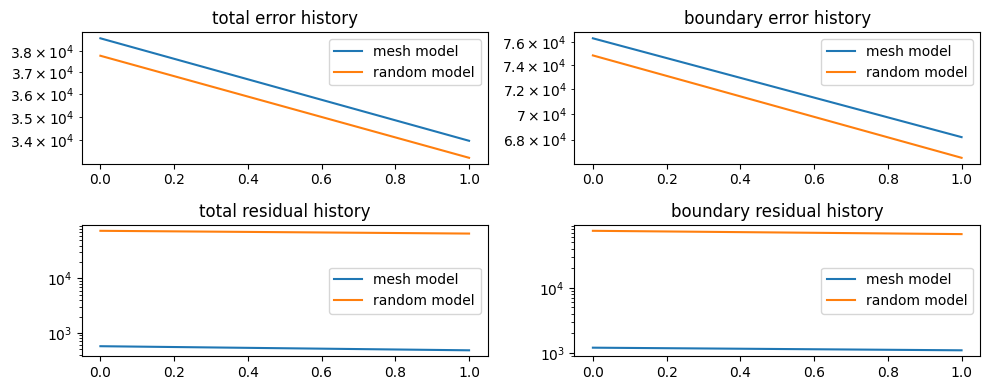

In [35]:
plot_all_errors([model, rand_model], ['mesh model', 'random model'])